## Evaluation Heatmap
As in Nettekoven 2024, we are using average group models and evaluating them now on a wider set of evaluation datasets. 

* Use Condition Half and cross evaluation
* Baseline subtraction after adding rest (if necessary)
* New extracted data after change of Functional Fusion 
* Even evaluated on same dataset, use L-O-O evaluation
* Use average cortical activity  


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import cortico_cereb_connectivity.globals as gl
import matplotlib.pyplot as plt

### Loading avg and loo models

In [2]:
method = 'L2reg'
train_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]#, "Fusion"]
eval_ds_list = ["MDTB", "Language", "Social", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
eval_names = ["MDTB", "Languagelocalizer", "Socialsocial", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC", "HCPur100"]
df_all = pd.DataFrame()
for i, dataset_name in enumerate(train_ds_list):

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-Cavg"],methods=[method],eval_data=eval_names,cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-Cavg"],methods=[method],eval_data=[eval_names[i]],cerebellum='MNISymC3')
    df_all = pd.concat([df_all, df], ignore_index=True)

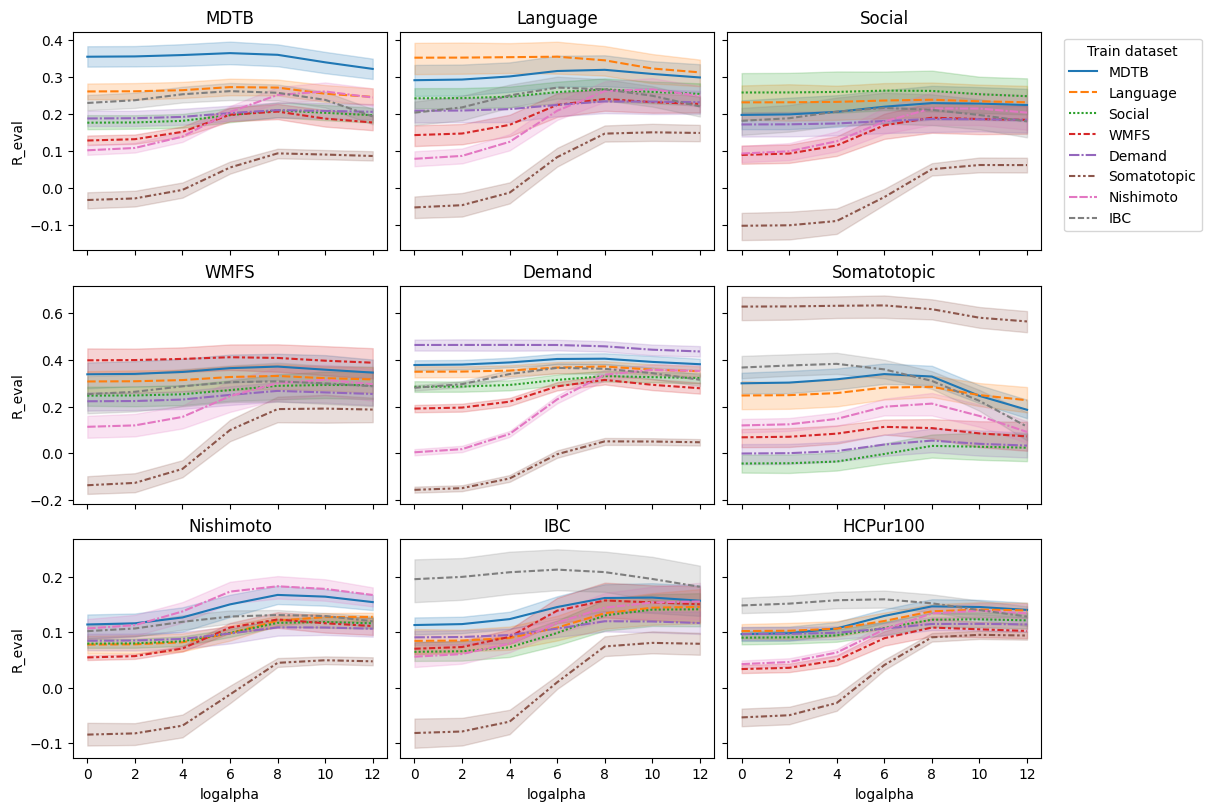

In [3]:
fig, axes = plt.subplots(np.ceil(len(eval_ds_list) / 3).astype(int), 3, figsize=(12, 8), sharey='row', sharex='col', constrained_layout=True)
for i,ed in enumerate(eval_ds_list):
    # Left subplot
    ax = axes[i // 3, i % 3]
    df_to_plot = df_all[(df_all.eval_dataset==ed) & ((df_all.train_dataset!=ed)
                                                     | (df_all.model.str.contains('loo')))]
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', style='train_dataset',
                     hue_order=train_ds_list, style_order=train_ds_list, ax=ax)
    ax.set_title(ed)

    if i == 2:
        ax.legend(title='Train dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.legend_.remove()

# Remove extra subplots if more than len(eval_ds_list)
if len(eval_ds_list) < axes.size:
    for j in range(len(eval_ds_list), axes.size):
        fig.delaxes(axes.flatten()[j])

### Find best hyperparameter

In [4]:
A = pd.pivot_table(df_all, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(train_ds_list)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                    \
logalpha           0.0       2.0       4.0       6.0       8.0       10.0   
train_dataset                                                               
MDTB           0.242059  0.243714  0.251905  0.268562  0.275797  0.264579   
Language       0.227867  0.228446  0.232004  0.243487  0.250907  0.243181   
Social         0.176748  0.177458  0.181965  0.197975  0.212701  0.210448   
WMFS           0.126727  0.129847  0.147843  0.193565  0.209886  0.199124   
Demand         0.203104  0.203571  0.206376  0.215153  0.222037  0.217741   
Somatotopic   -0.057426 -0.052702 -0.025126  0.056334  0.111633  0.113077   
Nishimoto      0.063603  0.070555  0.103743  0.178124  0.227646  0.233846   
IBC            0.212073  0.220539  0.240526  0.251236  0.245064  0.227647   

                         
logalpha           12.0  
train_dataset            
MDTB           0.253607  
Language       0.237936  
Social         0.207112  
WMFS           0.191922  
Demand         0.214275  
Somatotopic    0.110279  
Nishimoto      0.222202  
IBC            0.202267

,best_logalpha
train_dataset,
MDTB,8.0
Language,8.0
Social,8.0
WMFS,8.0
Demand,8.0
Somatotopic,10.0
Nishimoto,10.0
IBC,6.0


In [5]:
### load global model
df_global = pd.DataFrame()
for i,ds in enumerate(train_ds_list):
    d = gl.datasets.index(ds)
    train_dscode = ''.join(gl.dscode[:d]+gl.dscode[d+1:])
    train_dscode = train_dscode.replace('Ht', '')
    df = rm.comb_eval(models=[f'{train_dscode}-global-Cavg'], methods=[method], eval_data=[eval_names[i]], cerebellum='MNISymC3')
    df_global = pd.concat([df_global, df], ignore_index=True)
df = rm.comb_eval(models=[f"{''.join(gl.dscode).replace('Ht', '')}-global-Cavg"], methods=[method], eval_data=['HCPur100'], cerebellum='MNISymC3')
df_global = pd.concat([df_global, df], ignore_index=True)

In [6]:
A = pd.pivot_table(df_global, index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean')
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
display(bestla)
df_global['isbest'] = df_global.logalpha.values == bestla.loc[df_global.train_dataset].values.flatten()

R_eval                                                    \
logalpha                0         2         4         6         8         10   
train_dataset                                                                  
MdIbDeNiSoScLa    0.274414  0.320042  0.358319  0.370688  0.374468  0.365048   
MdWfDeNiSoScLa    0.086834  0.109467  0.149175  0.175319  0.182647  0.180629   
MdWfIbDeNiScLa    0.354227  0.401017  0.438004  0.432469  0.392632  0.299208   
MdWfIbDeNiSoLa    0.178287  0.202662  0.232012  0.248544  0.251093  0.246286   
MdWfIbDeNiSoSc    0.227101  0.284288  0.333528  0.349312  0.344731  0.327884   
MdWfIbDeNiSoScLa  0.117792  0.137206  0.159608  0.173798  0.179084  0.167803   
MdWfIbDeSoScLa    0.088441  0.117101  0.149293  0.165660  0.174117  0.168694   
MdWfIbNiSoScLa    0.220713  0.300945  0.378972  0.418256  0.422774  0.408882   
WfIbDeNiSoScLa    0.253002  0.274395  0.301618  0.323466  0.325911  0.309570   

                            
logalpha                12  
train_dataset               
MdIbDeNiSoScLa    0.336973  
MdWfDeNiSoScLa    0.173637  
MdWfIbDeNiScLa    0.164728  
MdWfIbDeNiSoLa    0.233972  
MdWfIbDeNiSoSc    0.301618  
MdWfIbDeNiSoScLa  0.151340  
MdWfIbDeSoScLa    0.151549  
MdWfIbNiSoScLa    0.386901  
WfIbDeNiSoScLa    0.273745

,best_logalpha
train_dataset,
MdIbDeNiSoScLa,8
MdWfDeNiSoScLa,8
MdWfIbDeNiScLa,4
MdWfIbDeNiSoLa,8
MdWfIbDeNiSoSc,6
MdWfIbDeNiSoScLa,8
MdWfIbDeSoScLa,8
MdWfIbNiSoScLa,8
WfIbDeNiSoScLa,8


### Evaluation Heatmap at best Hyperparameter 

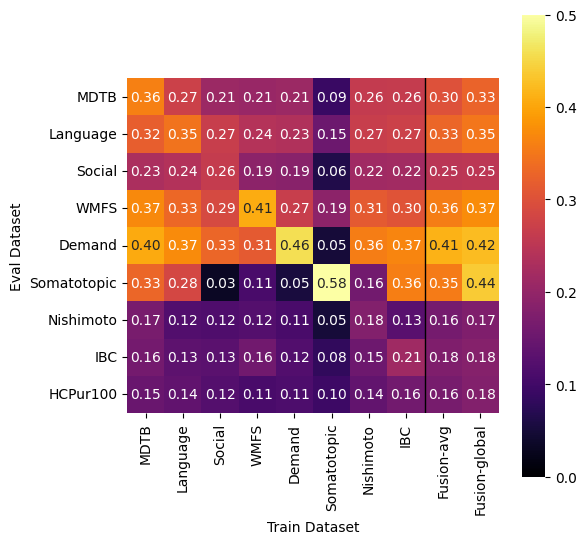

In [7]:
plt.figure(figsize=(6,6))

df_fuse = rm.comb_eval(models=['Fus-lodo-avg-Cavg'], methods=[method], eval_data=['all'], cerebellum='MNISymC3')
df_fuse['train_dataset'] = 'Fusion-avg'
df_global['train_dataset'] = 'Fusion-global'
df_to_plot = pd.concat([df_all[df_all.isbest], df_fuse, df_global[df_global.isbest]], ignore_index=True)

V = pd.pivot_table(df_to_plot, columns='train_dataset', index='eval_dataset', values='R_eval')
V = V.reindex(eval_ds_list, axis=0)
V = V.reindex(train_ds_list+['Fusion-avg', 'Fusion-global'], axis=1)

sns.heatmap(V.values, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=0.5, 
            xticklabels=V.columns.values, 
            yticklabels=V.index.values, square=True)
plt.axvline(x=V.shape[1] - 2, color='black', linewidth=1)
plt.xlabel('Train Dataset');
plt.ylabel('Eval Dataset');

### Evaluation Heatmap relative to the noise ceiling


In [8]:
# As a best noise ceiling estimate, we use the average of the upper and lower bounds
# Note that we could replace this with the square root of the average inter-subject correlation for the paper. 
df_to_plot['group_noiseceil_Y']=(df_to_plot['group_noiseceil_Y_upper'] + df_to_plot['group_noiseceil_Y_lower']) /2 
# Noise ceiling for each eval dataset
NC = pd.pivot_table(df_to_plot,values='group_noiseceil_Y',index='eval_dataset')
NC = NC.reindex(eval_ds_list, axis=0)
print(NC)




              group_noiseceil_Y
eval_dataset                   
MDTB                   0.405417
Language               0.412114
Social                 0.301559
WMFS                   0.449942
Demand                 0.484896
Somatotopic            0.688174
Nishimoto              0.336324
IBC                    0.281408
HCPur100               0.246714


[0.69219945 0.6232239  0.52366429 0.53346479 0.50440462 0.33215501
 0.58998784 0.64009335 0.69981119 0.74637742]
[0.04919241 0.05550854 0.0736159  0.06522734 0.07373603 0.06931904
 0.04833694 0.03775928 0.04251055 0.0382309 ]


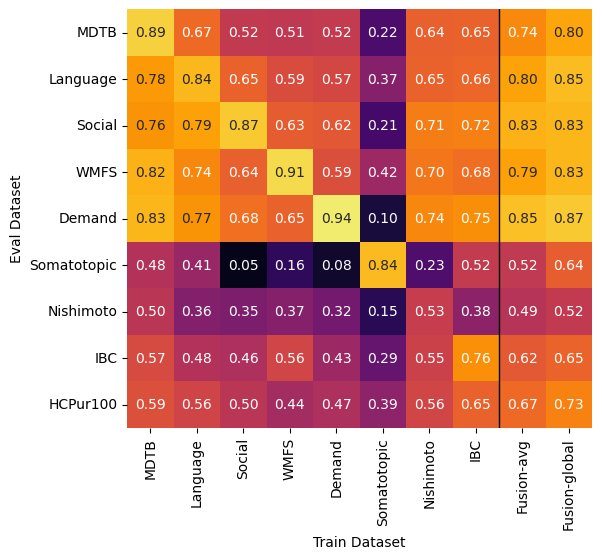

In [19]:
plt.figure(figsize=(6,6))
corrR = V.values/ NC.values
sns.heatmap(corrR, annot=True, fmt=".2f", cmap='inferno', vmin=0, vmax=1.0, 
            xticklabels=V.columns.values, 
            yticklabels=V.index.values, square=True, cbar=False)
plt.axvline(x=V.shape[1] - 2, color='black', linewidth=1)
plt.xlabel('Train Dataset');
plt.ylabel('Eval Dataset');

print(f'{corrR.mean(axis=0)}')
print(f'{corrR.std(axis=0)/np.sqrt(9)}')
plt.savefig(f'{gl.fig_dir}/modelperf_heatmap_normalized.pdf', bbox_inches='tight')



### Evaluation on HCP-task

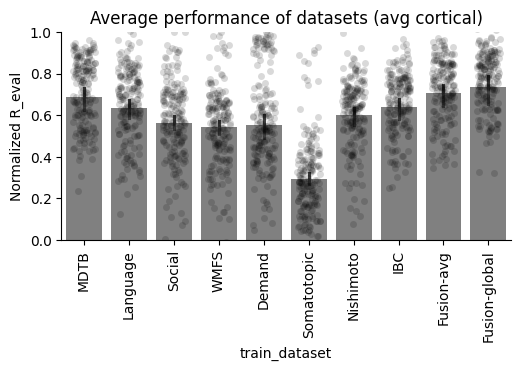

In [ ]:
plt.figure(figsize=(5.9, 2.7))
sns.barplot(data=df_to_plot, x='train_dataset', y=df_to_plot['R_eval'] / df_to_plot['group_noiseceil_Y'], order=train_ds_list+["Fusion-avg", "Fusion-global"], color=[0.5,0.5,0.5])
sns.stripplot(data=df_to_plot, x='train_dataset', y=df_to_plot['R_eval'] / df_to_plot['group_noiseceil_Y'], color=[0,0,0], alpha=0.15, jitter=0.25)
ax = plt.gca()
ax.set_xticks(np.arange(len(train_ds_list+["Fusion-avg", "Fusion-global"])))
a = ax.set_xticklabels(train_ds_list+["Fusion-avg", "Fusion-global"], rotation=90)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Average performance of datasets (avg cortical)')
ax.set_ylabel('Normalized R_eval')
ax.set_ylim(0, 1);
plt.savefig(f'{gl.fig_dir}/modelperf_barplot_normalized.pdf', bbox_inches='tight')